# Load NN autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py

In [22]:
from __future__ import division, print_function, absolute_import
%pylab inline

import tensorflow as tf
import numpy as np
import os
import librosa
import librosa.display
from  librosa.util import frame
from scipy.signal import resample
from IPython.display import Audio, display

%run ../utils.py
%run nnutils.py

rc_default()

SAVEFIG = False

Populating the interactive namespace from numpy and matplotlib


In [6]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'
fname = 'Grisey_partiels.wav'
fname = 'Xenakis_Metastasis.wav'
fname = 'battles_atlas.wav'


name = fname[:-4]

filename = path+fname

fs,track = wav2audio_segment(filename,100,160)

track = resample(track,int(track.size/2.0))
fs = fs/2.0

NFFT = 2**11
HOP = int(NFFT/4)

STFT = librosa.stft(track,n_fft=NFFT, hop_length=HOP,center=True).T
mel = librosa.feature.melspectrogram(S=abs(STFT)**2).T

X = abs(STFT/float(NFFT)/2)**2

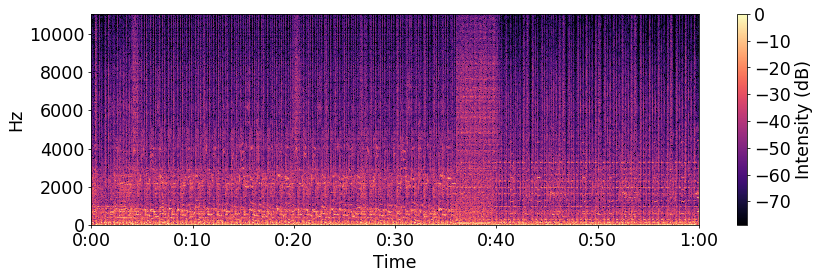

In [7]:
figure(figsize=(14,4))
librosa.display.specshow(librosa.logamplitude(X.T,ref_power=np.max),hop_length = HOP, sr=fs,y_axis='linear', x_axis='time')
colorbar(label='Intensity (dB)');

In [8]:
print("Dimensions: freq bins, time bins")
time_bins,freq_bins = X.shape
print(freq_bins,time_bins)

Dimensions: freq bins, time bins
1025 2584


## Create dataset  (Data class) with spectrum

In [9]:
Xlog = log10(X)
meanX = Xlog.mean(0)
stdX = Xlog.std(0)+0.001
Xnorm = (Xlog-meanX)/stdX
data = Data( Xnorm )
print(Xnorm.min(),Xnorm.max(),Xnorm.mean(0))

-7.77758 3.72829 [  6.62040611e-06   4.62348908e-06  -1.29066314e-06 ...,  -9.73534861e-06
  -9.32291357e-07   5.45910143e-06]


In [7]:
data.data[0].shape

(1025,)

## Neural Autoencoder parameters

In [10]:
learning_rate = 0.002

NNEURONS = 8
dimensions= [768,512,256,128,64,32,16,8]

# NNEURONS = 16
# dimensions= [768,512,256,128,64,32,16]

# NNEURONS = 32
# dimensions= [768,512,256,128,64,32]

In [11]:
nae = NAE(freq_bins,dimensions,activation=tf.nn.tanh,bias=True,learning_rate=learning_rate,stddev=0.1,reg_constant=0.01*0,meaninit=.00,identity=False)
nae.init_session()

nae.load("checkpoints/NAE1")

[1025, 768]
[768, 512]
[512, 256]
[256, 128]
[128, 64]
[64, 32]
[32, 16]
[16, 8]
[16, 32, 64, 128, 256, 512, 768, 8]
[8, 16]
[16, 32]
[32, 64]
[64, 128]
[128, 256]
[256, 512]
[512, 768]
[768, 8]
INFO:tensorflow:Restoring parameters from checkpoints/NAE1.ckpt
Model restored


In [12]:
sess = nae.get_session()
variable_dict = nae.get_variables_dict()

In [13]:
W = sess.run(variable_dict['W'])

In [12]:
# for w in W:
#     figure(figsize=(3,3))
#     imshow(sign(w)*log10(abs(w)),aspect='auto')
#     colorbar()

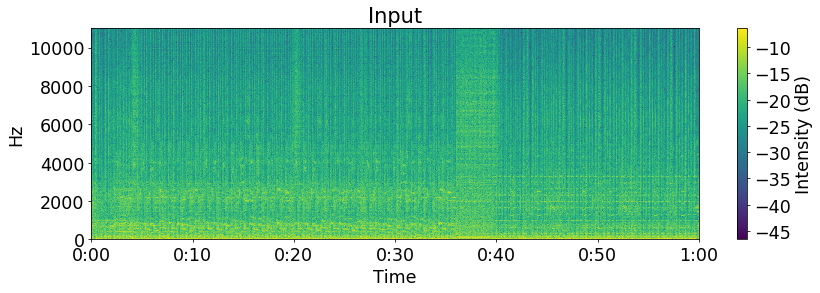

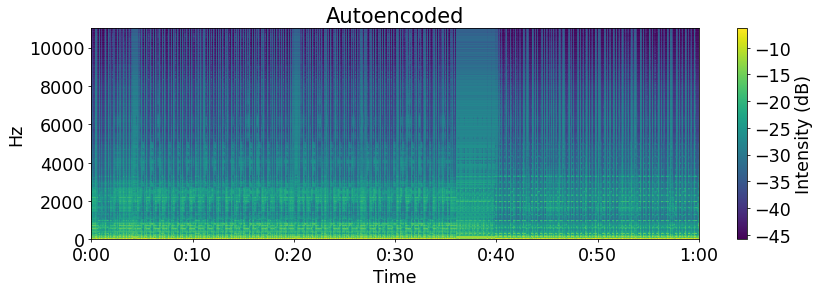

In [16]:
SAVEFIG = False

duration = track.size/fs
compare = range(0,time_bins,1)
recon = sess.run(variable_dict['Y'], feed_dict={ variable_dict['X']: data.data[compare]})

orig = data.data[compare]
M1 = orig*stdX+meanX

figure(figsize=(14,4))

librosa.display.specshow(3.*M1.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time',cmap = cm.viridis)

title('Input')
colorbar(label='Intensity (dB)')
if SAVEFIG:plt.savefig('figs/original')

Y = recon*stdX+meanX
M = (Y-Y.min())/(Y.max()-Y.min())*(M1.max()-M1.min())+M1.min()

figure(figsize=(14,4))

librosa.display.specshow(3.*M.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time',cmap = cm.viridis)

title('Autoencoded');
colorbar(label='Intensity (dB)');
if SAVEFIG: plt.savefig('figs/ae')

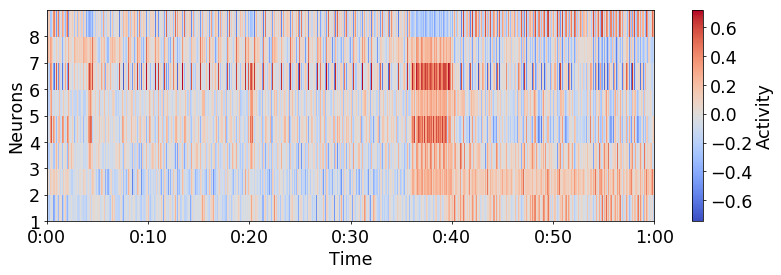

In [17]:
figure(figsize=(14,4))

Z = sess.run(variable_dict['z'], feed_dict={ variable_dict['X']: data.data[compare]})
idx = np.lexsort(Z)
librosa.display.specshow(Z.T,hop_length = HOP,sr=fs, x_axis='time')
yticks(range(0,Z[0].size),range(1,Z[0].size+1))
ylabel('Neurons')
colorbar(label='Activity')
if SAVEFIG: plt.savefig('figs/Z')

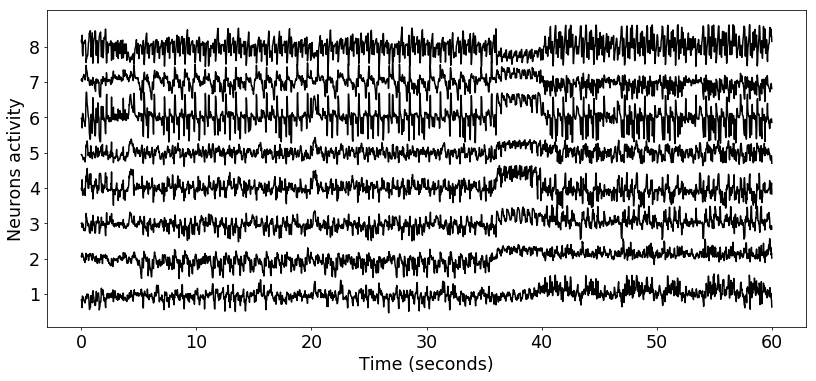

In [18]:
figure(figsize=(14,6))
t = linspace(0,duration,Z.shape[0])
plot(t,Z+arange(Z[0].size),'k');
xlabel('Time (seconds)')
ylabel('Neurons activity')
yticks(range(0,Z[0].size),range(1,Z[0].size+1));
if SAVEFIG: plt.savefig('figs/Zplot')

In [23]:
Y = recon*stdX+meanX
Y0 = (Y-Y.min())/(Y.max()-Y.min())*(M1.max()-M1.min())+M1.min()
Y = sqrt((10**Y0))*2*NFFT
MIX = (Y)
out = librosa.istft(MIX.T,hop_length=HOP, win_length=NFFT, center=True)
display(Audio(data=out,rate=fs))
display(Audio(data=track,rate=fs))